In [35]:
import numpy as np
import matplotlib.pyplot as plt

import string     # to load the ASCII characters
import random     # to shuffle the ASCII characters and create a substitution cipher
import re         # (REGEX library) to perform few string operations later 
import requests
import os
import textwrap 

# Building a Subsititution Cipher 

In [36]:
# Create two lists: One for the key, other for the value

lettersA = list(string.ascii_lowercase)
lettersB = list(string.ascii_lowercase) 

# Initialize a dictionary for true mapping between keys and cipher characters

true_mapping = {}

## Shuffle the second list of characters:     ...... to produce a random cipher

random.shuffle(lettersB)

## Create a loop to map the listB elements to listA keys.
# Store the true mapping in the true_mapping dictionary

for k,v in zip(lettersA, lettersB):
    true_mapping[k] = v
    
    
## Displaying the list elements and true_mapping dictionary
print("Key-elements: (Original Characters) \n")
print(lettersA)
print("\n")
print("Value-elements: (Cipher Characters) \n")
print(lettersB)
print("\n")
print("True- Mapping of the cipher with key values: \n")
print(true_mapping)

Key-elements: (Original Characters) 

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Value-elements: (Cipher Characters) 

['w', 'e', 'o', 'i', 'p', 't', 'x', 'g', 'l', 'm', 's', 'h', 'c', 'v', 'q', 'd', 'f', 'k', 'n', 'z', 'y', 'b', 'j', 'a', 'r', 'u']


True- Mapping of the cipher with key values: 

{'a': 'w', 'b': 'e', 'c': 'o', 'd': 'i', 'e': 'p', 'f': 't', 'g': 'x', 'h': 'g', 'i': 'l', 'j': 'm', 'k': 's', 'l': 'h', 'm': 'c', 'n': 'v', 'o': 'q', 'p': 'd', 'q': 'f', 'r': 'k', 's': 'n', 't': 'z', 'u': 'y', 'v': 'b', 'w': 'j', 'x': 'a', 'y': 'r', 'z': 'u'}


# Creating a Language Model

In [37]:

### Initialize the markov matrix (for Bigrams in the word)
#...... The matrix has 26 rows and 26 columns with A-Z on both axes. 
M = np.ones((26,26)) #Initialising the matrix with 1's for all combinations of letters(reason:Add one Smoothing)

### Initialize a numpy array (for unigrams: Precisely, for the first letter in the word)
#Initial state distribution 
pi = np.zeros(26)

### Function to update the Markov matrix 
# .... Markov matrix is a square matrix that takes values of probabilities in it
# parameters: ch1 - represents the starting character; ch2 represents the ending character
def update_transition(ch1, ch2):
    i = ord(ch1) - 97    # ord() converts the chracter to it's ASCII value
    j = ord(ch2) - 97    # for i,j: we are subtracting 97 from both to get the index value of the matrix starting 
                         # ... from 0 to 25 (since, we have 26 rows and 26 columns)
                         # Because ASCII values for lowercase 'a' starts with 97
            
    M[i,j] += 1          # Updating the Markov matrix M with 1 for every ocurrence of the bigram
    
# Function to update the initial state distribution
def update_pi(ch):
    i = ord(ch) - 97
    pi[i] += 1

### Function for finding the Log probability of a single WORD (single token)
# Parameter: input word

def get_word_prob(word):
    i = ord(word[0]) - 97
    logp = np.log(pi[i])
    
    for ch in word[1:]:        # for individual bigrams in the word (Example: for "CAT", bigrams are: CA, AT)
        j = ord(ch) - 97       # Calculating the index position of second letter in the bigram
        logp += np.log(M[i,j]) # Calculating and summing the log probability of each bigram to existing value
        i = j                  # Updating the first letter of the new bigram
        
    return logp

### Finding the log probability of the sequence of words (i.e., sentence)
# Parameter: imput sentence

def get_sequence_prob(words):
    # if input is a string
    if type(words) == str:
        # Convert the string(sentence) into individual tokens(words) and store them in an array
        words = str.split(words)  # 'words' is now an array
        
    logp = 0 
    for word in words:
        logp += get_word_prob(word)  # Calling the function for every word and Adding individual word probabilities
        
    return logp  # this is the log probability of entire sentence!
        
    


# Training the Language Model

In [38]:
# download the file
if not os.path.exists("moby_dick.txt"):
    print("Downloading Moby dick....")
    r = requests.get("https://lazyprogrammer.me/course_files/moby_dick.txt")
    with open("moby_dick.txt", 'w') as f: 
        f.write(r.content.decode())  # decode function turns the byte array to a string
        
# If the file doesn't exist already on your computer, you are downloading it from the link mentioned and 
# saving it as a file on your computer 


In [39]:
# Data cleaning 

# remove non - alpha chracters
regex = re.compile('[^a-zA-Z]') # Finds any character that is NOT a-z or A-Z

# Loop that reads Moby Dick line by line

for line in open('moby_dick.txt'):
    line = line.rstrip() # Stripping out white spaces
    
    if line:
        line = regex.sub(" ", line) #replacing non -alpha characters with space
        
        tokens = line.lower().split() # splitting the line into words and converting to lowercase
        
        for token in tokens: # for updating the pi and M with count of letter occurences
            
            # first letter
            ch0 = token[0]
            update_pi(ch0)
            
            # other letters
            for ch1 in token[1:]:
                update_transition(ch0, ch1)
                ch0 = ch1
            
# normalize the probabilities 
# .... converting the counts to probabilities: (individual count / total count) gives us the probabaility
# In a transition matrix 'M' the row and column totals must sum up to 1: because they are probabilities!

pi /= pi.sum() 
M /= M.sum(axis = 1, keepdims = True)

        
    

# Encode and Decode a message

In [40]:
# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [41]:
# Encoding a message

#.... the function defined below takes a raw message (as above) and returns a cipher text 
# encoding is done using a subsitution cipher 

def encode_message(msg):
    msg = msg.lower() # Firstly, Lowercase all letters because mapping function contains only lowercase letters
    
    msg = regex.sub(' ', msg) # Substituting all the non-alpha characters with a space
    
    # Building the coded message
    # loop for encoding individual word
    coded_msg = [] 
    for ch in msg:
        
        coded_ch = ch                   # for the case where ch could be a non - alpha character (for space)
        
        if ch in true_mapping:           # if ch is present in the mapping dictionary
            coded_ch = true_mapping[ch] # add the cipher value from dictionary to the list
        coded_msg.append(coded_ch)
     
    return ''.join(coded_msg)      # returns final string where each word is JOINED

encoded_message = encode_message(original_message)

In [42]:
# Decoding a message

def decode_message(msg, word_map):
    decoded_msg = []
    
    for ch in msg:
        decoded_ch = ch # for a space
        
        if ch in word_map:
            decoded_ch = word_map[ch]
        decoded_msg.append(decoded_ch)
    return ''.join(decoded_msg)

# Evolutionary (Genetic) Algorithm

In [43]:
# Initialization point
dna_pool = []

for _ in range(20):  # we need a loop that iterates 20 times
    dna = list(string.ascii_lowercase)  # dna string is a list containing lowercase letters
    random.shuffle(dna)   # randomly shuffling the dna string to create a random mapping to dna pool
    dna_pool.append(dna)   # appending the random mapping to dna_pool so that by the end of the loop we have 
                           #... 20 random dna strings


# Function to evolve offspring
# parameters: dna_pool , n_children: no. of children each individual will create
def evolve_offspring(dna_pool, n_children):
    offspring = [] 
    
    for dna in dna_pool:               # to iterate over no. of parents 
        for _ in range(n_children):    # to iterate over no. of children
            # In order to create a child, we perform random swapping
            
            copy = dna.copy()         # making a copy of the parent, so that we don't overwrite it!
            j = np.random.randint(len(copy))   # j,k are the positions that we want to swap (randomly generated)
            k = np.random.randint(len(copy))   # j,k are nothing but two random numbers between 0 and 25
            
            
            # now, we do the swapping
            temp = copy[j]
            copy[j] = copy[k]
            copy[k] = temp
            
            offspring.append(copy) # We are assigning the mutated (swapped) string to offspring
            
    return offspring + dna_pool # Offspring and parent lists are appended ---- Final population
            
    
    

In [46]:
# loop that runs the genetic algorithm

num_iters = 1000 # number of iterations of the loop( = no. of offsprings we want to evolve)
scores = np.zeros(num_iters)# an array that stores average score at each iteration
best_dna = None # best DNA corresponds to best map and best map corresponds to best score
best_map = None
best_score = float ('-inf') # -infinity is the minimum possible score, that's why best_score is INITIALIZED to -inf

for i in range(num_iters):
    
    # checking if it's the first iteration: If it's not the first iteration we needn't create an offspring
    if i > 0:
        # creating new offspring
        dna_pool = evolve_offspring(dna_pool, 3)
        
    # Calculate the score for each dna string
    dna2score = {} # key: DNA string , value: score
    for dna in dna_pool: #inside the loop,we are converting dna string to mapping,so we can use to decode ciphertext
        #populate map
        current_map = {}
        for k,v in zip(lettersA, dna):
            current_map[k] = v
        
        decoded_message = decode_message(encoded_message, current_map) # decodes the cipher using current map
        score = get_sequence_prob(decoded_message)  # calculates log likelihood of the decoded message
        
        # Storing the above score to the dictionary 
        
        # the dna string is a list, and lists are not allowed to be used as dictionary keys
        #... so we convert the list to string
        dna2score[''.join(dna)] = score
        
        
        # Compare the scores
        if score > best_score:
            best_dna = dna
            best_map = current_map
            best_score = score
    
    # Calculate the average score of the population and store it in an array
    scores[i] = np.mean(list(dna2score.values()))
    
    # Survival of the fittest!
    # keep the best 5 dna.... keeping the most 'fit' individuals 
    sorted_dna = sorted(dna2score.items(),key = lambda x: x[1], reverse = True) 
    # Above line: key argument we're passing x[1]-- we care about the key and not the value to sort values
    
    dna_pool = [list(k) for k, v in sorted_dna[:5]]

    if i % 200 == 0:
        print("iter:", i, "score:", scores[i], "best so far:", best_score)
    
            

iter: 0 score: -2108.887413581533 best so far: -1722.6266405316976
iter: 200 score: -1063.0154275835757 best so far: -939.2153552962346
iter: 400 score: -1011.3183638268388 best so far: -929.5902922650557
iter: 600 score: -1006.8402548426634 best so far: -929.5902922650557
iter: 800 score: -1060.1270256129928 best so far: -929.5902922650557


In [47]:
# use best score
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -929.5902922650557
LL of true message: -933.0312453751817
true: k, pred: q
true: q, pred: z
true: z, pred: k


In [48]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

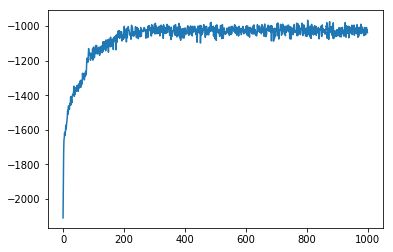

In [49]:
plt.plot(scores)
plt.show()